In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgi

from src import *

In [ ]:
H = xgi.read_hif("data/SOMAR/deidentified_starterpack_hif.json")

In [5]:
H.num_nodes, H.num_edges

(1671681, 301322)

In [ ]:
def hypergraph_kcore(H):
    """
    Computes the k-core decomposition of a hypergraph H.

    Before processing, node labels and hyperedge IDs are converted to integer indices starting from zero.

    Parameters:
    H (xgi.Hypergraph): The input hypergraph.

    Returns:
    dict: A dictionary mapping original node labels to their core numbers.
    """
    from collections import defaultdict
    from tqdm import tqdm

    original_nodes = list(H.nodes)
    node_to_int = {node: idx for idx, node in enumerate(original_nodes)}
    int_to_node = {idx: node for node, idx in node_to_int.items()}

    original_edges = list(H.edges)
    edge_to_int = {edge_id: idx for idx, edge_id in enumerate(original_edges)}

    node_degrees = {}        # node_idx: degree
    node_core = {}           # node_idx: core number
    node_to_edges = defaultdict(set)  # node_idx: set of edge indices
    edge_to_nodes = {}                 # edge_idx: set of node indices

    for original_edge_id in H.edges:
        edge_idx = edge_to_int[original_edge_id]
        nodes_in_edge = set(node_to_int[node] for node in H.edges.members(original_edge_id))
        edge_to_nodes[edge_idx] = nodes_in_edge.copy()
        for node_idx in nodes_in_edge:
            node_to_edges[node_idx].add(edge_idx)

    for node_idx in node_to_int.values():
        node_degrees[node_idx] = len(node_to_edges[node_idx])

    if not node_degrees:
        return {}


    degree_buckets = defaultdict(set)
    for node_idx, degree in node_degrees.items():
        degree_buckets[degree].add(node_idx)

    min_degree = min(degree_buckets.keys())
    num_nodes_remaining = len(node_degrees)

    pbar = tqdm(total=num_nodes_remaining, desc="Processing nodes")

    while num_nodes_remaining > 0:
        while min_degree not in degree_buckets or not degree_buckets[min_degree]:
            possible_degrees = [deg for deg in degree_buckets.keys() if degree_buckets[deg]]
            if possible_degrees:
                min_degree = min(possible_degrees)
            else:
                break  # All nodes have been processed

        if min_degree not in degree_buckets or not degree_buckets[min_degree]:
            break  # All nodes have been processed

        # Remove a single node with minimal degree
        node_idx = degree_buckets[min_degree].pop()
        node_core[node_idx] = min_degree
        num_nodes_remaining -= 1
        pbar.update(1)

        # Remove node from edges and update degrees
        for edge_idx in list(node_to_edges[node_idx]):
            edge_to_nodes[edge_idx].remove(node_idx)
            if len(edge_to_nodes[edge_idx]) < 2:
                # edge becomes invalid; remove it
                for u in edge_to_nodes[edge_idx]:
                    if edge_idx in node_to_edges[u]:
                        node_to_edges[u].remove(edge_idx)
                        old_degree = node_degrees[u]
                        if old_degree > 0:
                            degree_buckets[old_degree].discard(u)
                        node_degrees[u] -= 1
                        new_degree = node_degrees[u]
                        degree_buckets[new_degree].add(u)
                del edge_to_nodes[edge_idx]
            else:
                # edge is still valid; degrees remain unchanged
                pass

            node_to_edges[node_idx].remove(edge_idx)

        # Clean up
        del node_to_edges[node_idx]

    pbar.close()

    # map back to original node labels
    core_numbers = {int_to_node[node_idx]: core_num for node_idx, core_num in node_core.items()}

    return core_numbers

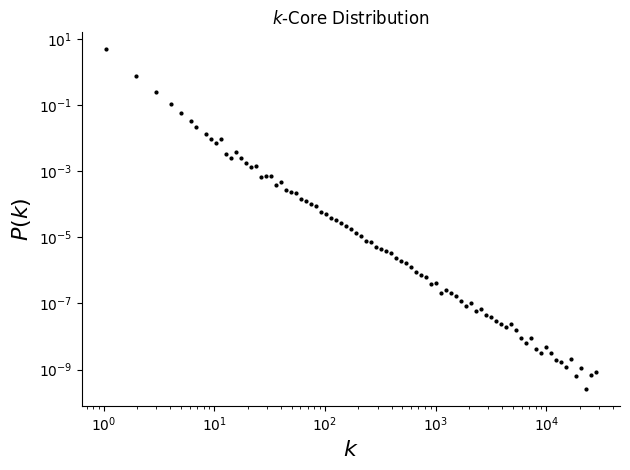

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

core_numbers = hypergraph_kcore(H)

for node, core in core_numbers.items():
    H.nodes[node]['kcore'] = core

kcore_values = [H.nodes[node]['kcore'] for node in H.nodes]

kcore_values = [k for k in kcore_values if k > 0]

min_core = min(kcore_values)
max_core = max(kcore_values)

bins = np.logspace(np.log10(min_core), np.log10(max_core), num=100)

hist, bin_edges = np.histogram(kcore_values, bins=bins, density=True)

bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

plt.loglog(bin_centers, hist, 'ko', markersize=2)

plt.title(r"$k$-Core Distribution")
plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
sns.despine()
plt.tight_layout()

plt.savefig("kcore_distribution.pdf")

plt.show()